# Histopathologic Cancer Detection

We're going to tackle binary image classification with the newly released fastai-v1 library.

First we turn on autoreload incase we update any of our modules while running the notebook. We also include the magic matplotlib inline command to make sure our plots stay in our notebook after we've run it.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

First let's download the data using the [Kaggle API](https://github.com/Kaggle/kaggle-api) and unzip the test and training data. By placing an exclamation point at the start of each line, we can run bash commands in jupyter notebook.

In [ ]:
!kaggle competitions download histopathologic-cancer-detection
!unzip -q train.zip -d train/
!unzip -q test.zip -d test/

In [3]:
path = Path('./')

First we need to gather our data. We will do this by pulling from the folders of images we downloaded from kaggle and placing them into the go-to image data object for fastai-v1: an ```ImageDataBunch```. 

The ```from_folder``` method defaults to searching from a 'train/' and 'valid/' folder to create the datasets. You can easily override this behavior by passing the path to the train or valid folders. Also, as we do not have a specific validation data set, we will simply set the ```valid_pct=0.2``` to randomly select 20% of the training sample as a validation set.

Finally, we need to specify if there are transforms we plan on augmenting the data with. Data augmentation is very useful as it not only allows us to create a larger amount of data to train with, but makes our neural net more generalizable! The ```get_transforms``` function defaults to dihedral flips, up to 10 degree rotations (in either direction), applying up to a 10% zoom along with a few others (check out the source code to learn more, it's where i'm pulling all this info from!)

Also as Joni Juvonen pointed out in his [notebook](https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai): 
> We know that the label of the image is influenced only by the center region (32 x 32px) so it would make sense to crop our data to that region only. However, some useful information about the surroundings could be lost if we crop too close.  This hypothesis could be confirmed by training models with varying crop sizes. My initial results with 32 x 32px size showed worse performance than with 48 x 48px but I haven't done a search for optimal size.

So for now we'll crop to 48 pixels and come back to this point later

In [4]:
tfms = get_transforms()
data = ImageDataBunch.from_folder(path,size = 48, valid_pct=0.2,
                                  ds_tfms=tfms,bs=128)

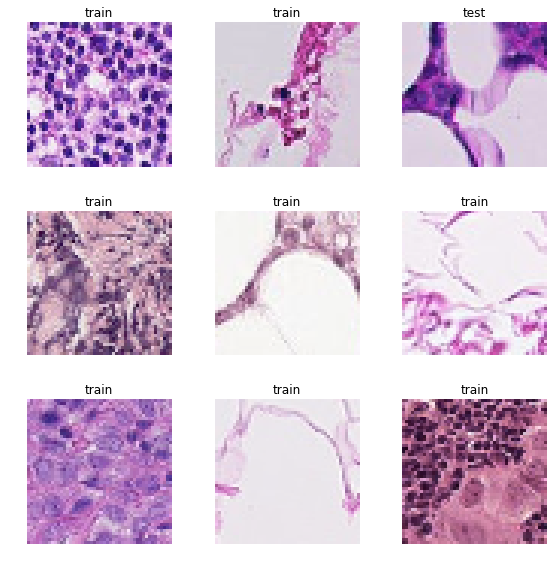

In [5]:
data.show_batch(rows = 3, figsize=(8,8))

Now let's move on to actually creating a model! We'll start from a pretrained model to see if we can gain anything from the preset activations of an already successful model.

In [5]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


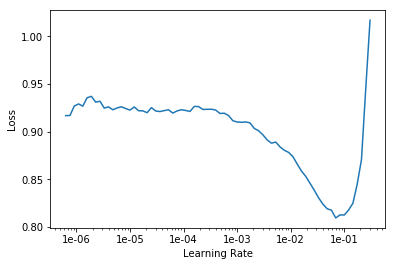

In [78]:
learn.lr_find()
learn.recorder.plot()

In [79]:
lr = 1e-2
learn.fit(1,lr)

epoch,train_loss,valid_loss,accuracy
1,0.496852,0.496922,0.809157


In [80]:
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.469478,0.473252,0.813518


We can save our model's activations by using the save feature. That way, we can save any training we've done and come back to it at a later date.

In [86]:
learn.freeze()
learn.save('res50_2epochsfrozen')

Loading up a model's activations is just as easy. Just remember that we need to define the architecture of the model (contained within the ```learn``` variable) before loading up the activations.

In [6]:
learn.load('res50_2epochsfrozen')
learn.unfreeze()

Now as has been suggested by Leslie Smith's 1cycle policy

epoch,train_loss,valid_loss,accuracy
1,0.433324,0.415838,0.838403


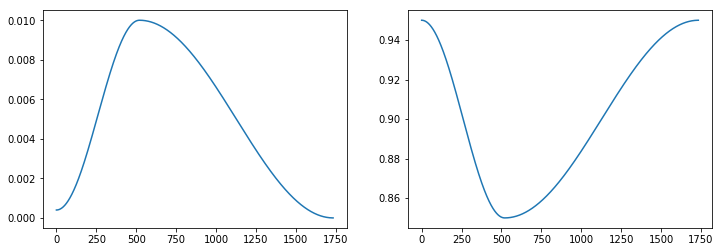

In [20]:
learn.fit_one_cycle(1, max_lr=slice(1e-2))
learn.recorder.plot_lr(show_moms=True)

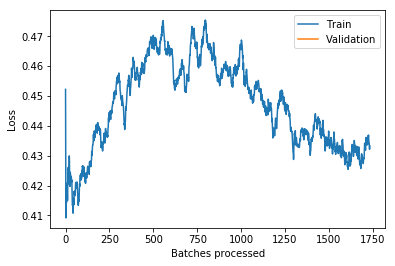

In [21]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-2))

epoch,train_loss,valid_loss,accuracy
1,0.446564,0.612841,0.724286


In [15]:
log_preds, targs = learn.get_preds()
log_preds.shape
probs = np.exp(log_preds[:,1])